In [144]:
%load_ext autoreload
%autoreload 2
from repeater import TakaAkiRepeaterCatalog
from earthquake import EarthquakeCatalog
import matplotlib as mpl
from matplotlib import pyplot as plt
import numpy as np
from pathlib import Path

mpl.rc('figure', dpi=100)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[None]

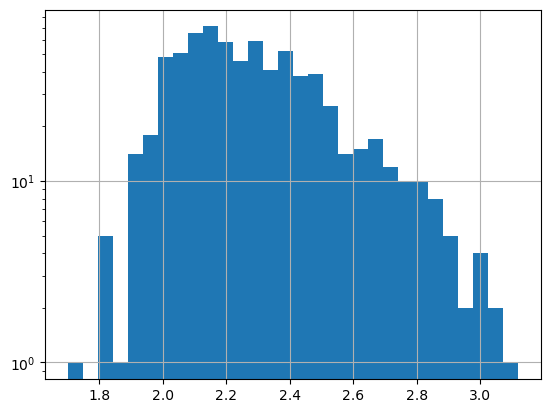

In [153]:
ax = repeaters.catalog.mag.hist(bins=30)
ax.set(yscale='log')

In [145]:
# repeaters = WaldhauserRepeaterCatalog()
repeaters = (
    TakaAkiRepeaterCatalog(    
        filename="SJBPK.freq8-24Hz_maxdist3_coh9650_linkage_cluster.txt"
    )
    .slice_by('COV', 0, 0.5)
    .slice_by('NEV', 5)
    .slice_by('time', np.datetime64('1985-01-01'), np.datetime64('2004-01-01'))
)

minimum_avg_repeater_magnitude = 2.6

for family in repeaters.catalog.family:
    
    if ( repeaters.catalog.loc[repeaters.catalog.family == family].mag.mean()
        < minimum_avg_repeater_magnitude
    ):
        repeaters.catalog = repeaters.catalog.loc[
            repeaters.catalog.family != family
        ]


# repeaters = IgarashiRepeaterCatalog().get_time_slice(np.datetime64('1990-01-01'), np.datetime64('2011-01-01'))

families = repeaters.get_families()

data_directory = Path('data/earthquake_catalogs/')
earthquake_metadata = {
    "starttime": '1990-01-01',
    "endtime": '2024-01-01',
    "latitude_range": [-90,90],
    "longitude_range": [-180,180],
    "minimum_magnitude": 1, 
} 

minimum_avg_earthquake_magnitude = 2.5

nearby_earthquakes = (
    EarthquakeCatalog(
        filename=data_directory/'global_ALL.csv',
        kwargs=earthquake_metadata,
    ) # expect warnings about loading existing catalog and Nan values
    .slice_by('mag',minimum_avg_earthquake_magnitude)
    .intersection(repeaters)
)


/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/repeater.py:81: RuntimeWarning: invalid value encountered in double_scalars
  return bias_correction * np.std(dt) / np.mean(dt)
/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/earthquake.py:176: UserWarning: Using existing data/earthquake_catalogs/global_ALL.csv
  warnings.warn(f"Using existing {filename}")
/Users/kdascher/Documents/Documents/Berkeley/Projects/Exploratory_projects/repeaters/earthquake.py:182: UserWarning: 27913 NaN values found in catalog. Removing rows with NaN values.
  warnings.warn(


In [130]:
def get_phase(tq, t: np.ndarray):
    # note: not vectorized

    if tq < min(t) or tq > max(t):
        return np.NaN

    
    dt = (t - tq) / np.timedelta64(1, "D")

    if np.min(np.abs(dt)) == 0:
        index = np.argmin(np.abs(dt))
        t1 = 0
        if index == 0:
            T = dt[index + 1]
        elif index == len(dt) - 1:
            T = dt[index - 1]
        else:
            T = np.mean(dt[[index - 1, index + 1]])

    else:
        dt_pos = dt[dt >= 0]
        dt_neg = dt[dt < 0]

        t1 = min(-dt_neg)
        t2 = min(dt_pos)

        T = t1 + t2

    phase = 2 * np.pi * t1 / T

    return phase


def get_phase_time_series(tq, t):
    return np.array([get_phase(itq, t) for itq in tq])

def catalog2catalog_order_parameter(cq, c):
    phases = get_phase_time_series(cq.catalog.time.values, c.catalog.time.values)
    phases = phases[~np.isnan(phases)]
    if np.any(phases):
        order_parameter = np.abs(np.nanmean(np.exp(1j * phases)))
    else:
        order_parameter = np.nan

    return order_parameter


def catalog2catalog_phase(cq, c):
    phases = get_phase_time_series(cq.catalog.time.values, c.catalog.time.values)
    return phases[~np.isnan(phases)]

In [131]:
get_phase(np.array([1]),np.array([0,2]))

UFuncTypeError: ufunc 'divide' cannot use operands with types dtype('int64') and dtype('<m8[D]')

## Establishing phase locking in a population, using repeaters as metronomes

For each repeater family we search for other families in the imediate neighborhood. The order parameter:

$$ R = \dfrac{1}{N}\sum_{i=1}^N e^{i\phi_i} $$

will approach 1 for a population that has phase locked. Subtle effects related to higher order synchronization (e.g. period doubling) imply that R may not be a perfect measurmeent of synchronization. We make the following hypthesess:
- The order paramters will be higher if there are fewer neighboring earthquake which, owing to their irregularity may tend to disrupt synchronization.  
- The order parameter will be disrupted by the occurence of regional large earthquakes - for instance after the Parkfield earthquake.
- The order parameter will be higher in a smaller radius as the mutual coupling is higher.
- More uniform magnitude distributions will feature a higher order parameter

Since $\phi_i$ cannot be known in an absolute sense we make the following assuption that if the population synchronized, particularly regular repeater can serve a metronome. In this sense, for every repeater we measure:

$$ R \approx \dfrac{1}{N}\sum_{i=1}^N e^{i 2\pi\dfrac{t_i - t_j}{t_{j+1}-t_j}} $$  

In [132]:
search_radius = 1  # km
order_parameter = []
number_of_neighboring_repeaters = []
number_of_neighboring_earthquakes = []
order_parameter = []
earthquake_order_parameter = []
phases = []
earthquake_phases = []


for family in families:
    family_ID = family.catalog.family.values[0]
    neighboring_repeaters = repeaters.intersection(family, search_radius).slice_by('mag',-100, family.catalog.mag.mean())   # KDC - ONLY CONSIDERING NEARBY SMALLER FAMILIES TO INTRODUCE ASYM.
    neighboring_earthquakes = nearby_earthquakes.intersection(family, search_radius).slice_by('mag',-100, family.catalog.mag.mean())   # KDC - ONLY CONSIDERING NEARBY SMALLER FAMILIES TO INTRODUCE ASYM.
    neighboring_repeaters.catalog = neighboring_repeaters.catalog.loc[
        neighboring_repeaters.catalog.family != family_ID
    ]

    order_parameter.append(
        catalog2catalog_order_parameter(neighboring_repeaters, family)
    )
    
    earthquake_order_parameter.append(
        catalog2catalog_order_parameter(neighboring_earthquakes, family)
    )

    number_of_neighboring_repeaters.append(len(neighboring_repeaters))
    number_of_neighboring_earthquakes.append(len(neighboring_earthquakes))
    
    phases.append(catalog2catalog_phase(neighboring_repeaters, family))
    earthquake_phases.append(catalog2catalog_phase(neighboring_earthquakes, family))

order_parameter = np.array(order_parameter)
earthquake_order_parameter = np.array(earthquake_order_parameter)

In [133]:
number_of_trial = 1000
normalized_order_parameter = []
for p, n in zip(order_parameter, number_of_neighboring_repeaters):
   if n > 0:
      normalization = np.mean(
         [
            np.abs(np.sum(np.exp(np.random.uniform(0,2*np.pi,n)*1j)))/n
            for _ in range(number_of_trial)
         ]
      )
      
      normalized_order_parameter.append(
         p/normalization
      )
   else:
      normalized_order_parameter.append(0)
   

In [134]:
bins = np.linspace(0, 2 * np.pi, 20)

counts = []
for phase in phases:
    if np.any(phase):
        counts.append(np.histogram(phase, bins=bins)[0])

cummulative_counts = np.cumsum(counts, axis=0)

/var/folders/nl/dmjw3blj27nd4c04v3dxnqw40000gn/T/ipykernel_82625/2335408072.py:34: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=None)


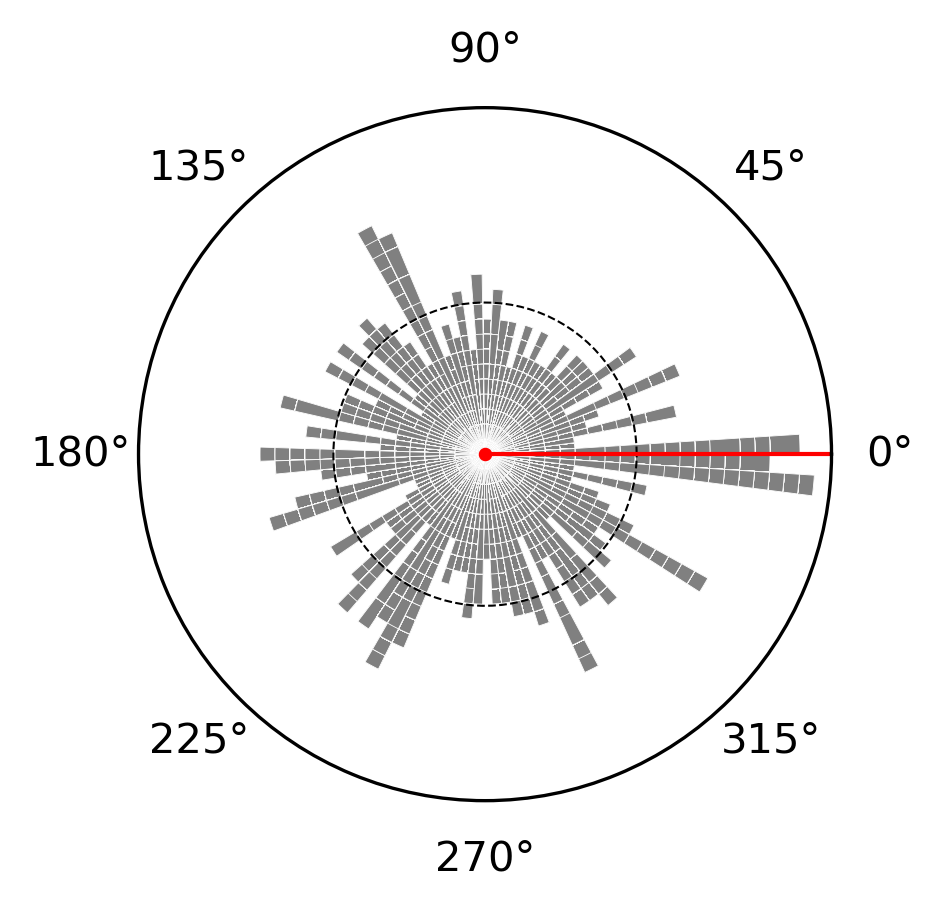

In [135]:
plt.figure(figsize=(3, 3), dpi=300)
ax = plt.subplot(polar=True)

number_of_divisions = 100
bins = np.linspace(0, 2 * np.pi, number_of_divisions)

counts = []
for phase in phases:
    counts.append(np.histogram(phase, bins)[0])

cummulative_counts = np.cumsum(counts, axis=0)

for i in range(len(phases)):
    ax.bar(
        0.5 * (bins[:-1] + bins[1:]),
        cummulative_counts[-i, :],
        width=2 * np.pi / number_of_divisions,
        color="grey",
        linewidth=0.2,
        edgecolor="white",
    )

ax.plot(
    np.linspace(0, 2 * np.pi, 100),
    [np.mean(cummulative_counts[-1, :])] * 100,
    c="k",
    lw=0.5,
    ls="--",
)

ax.axvline(c="r", lw=1)
ax.scatter(0, 0, c="r", s=5)
ax.set_rticks([])
plt.grid(b=None)


[None, None, Text(0.5, 0, 'Search radius'), Text(0, 0.5, 'Scale break')]

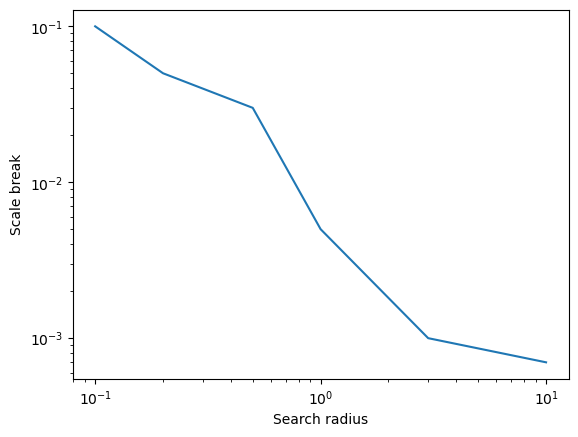

In [136]:
distance = [0.1,0.2,0.5,1,3,10]
scale_break = [0.1,0.05,0.03,0.005,0.001,0.0007]
fig, ax = plt.subplots()
ax.plot(distance, scale_break)
ax.set(
    xscale='log',
    yscale='log',
    xlabel='Search radius',
    ylabel='Scale break',
)

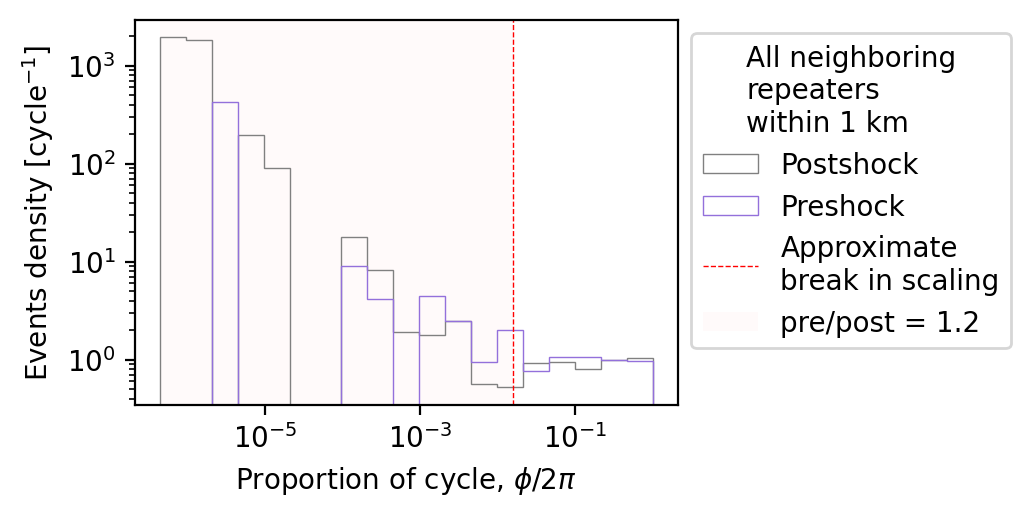

In [137]:
cycle = np.concatenate(phases) / (np.pi * 2)

fig, ax = plt.subplots(figsize=(3.5, 2.5), dpi=200)
bins = np.logspace(
    np.log10(np.min(cycle)),
    np.log10(np.max(cycle)),
    20,
)

ax.hist(
    cycle,
    bins=bins,
    log=True,
    color="grey",
    linewidth=0.5,
    histtype="step",
    density=True,
    label='Postshock'
)


ax.hist(
    1 - cycle,
    bins=bins,
    log=True,
    color="mediumpurple",
    linewidth=0.5,
    histtype="step",
    density=True,
    label='Preshock'
)

cutoff = 10**-1.8
ax.axvline(cutoff, c="r", ls="--", lw=0.5, label="Approximate\nbreak in scaling")
ax.axvspan(bins[0],cutoff,facecolor='r', alpha=0.02, label=f"pre/post = {np.sum(1-cycle < cutoff)/np.sum(cycle<cutoff):0.1f}")

ax.set(xscale="log", xlabel=r"Proportion of cycle, $\phi/2\pi$", ylabel=r'Events density [cycle$^{-1}$]')
lg = ax.legend(bbox_to_anchor=[1, 1])
lg.set_title(f"All neighboring\nrepeaters\nwithin {search_radius} km")

print()

In [138]:
3e7*1e-9

0.030000000000000002

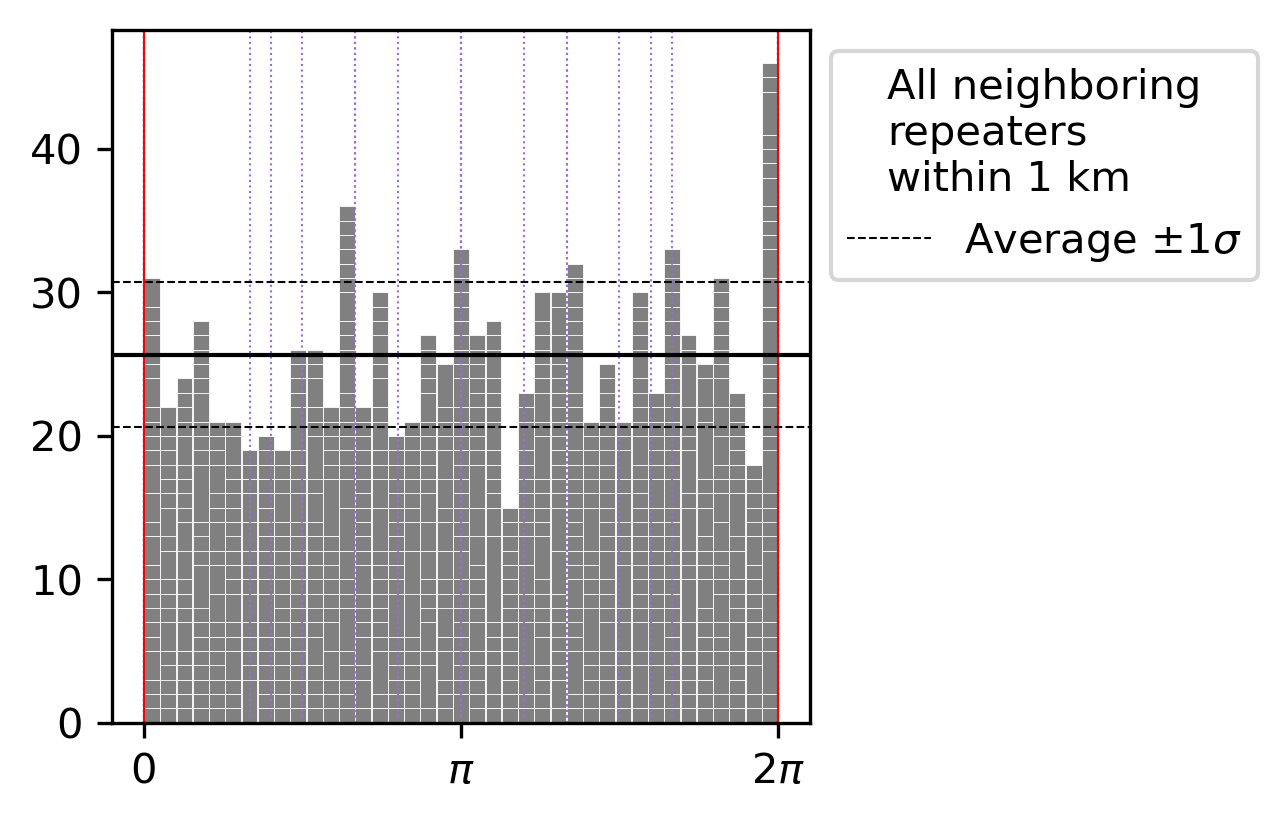

In [139]:

plt.figure(figsize=(3, 3), dpi=300)
ax = plt.subplot()

for k in range(6):
    phi = np.linspace(0,2*np.pi,k+2)
    [ax.axvline(i_phi,c="mediumpurple", lw=0.5, ls=':') for i_phi in phi]
    


number_of_divisions = 40
bins = np.linspace(0, 2 * np.pi, number_of_divisions)

counts = []
for phase in phases:
    counts.append(np.histogram(phase, bins)[0])

cummulative_counts = np.cumsum(counts, axis=0)

for i in range(len(phases)):
    ax.bar(
        0.5 * (bins[:-1] + bins[1:]),
        cummulative_counts[-i, :],
        width=2 * np.pi / number_of_divisions,
        color="grey",
        linewidth=0.2,
        edgecolor="white",
    )

ax.axvline(c="r", lw=0.5)
ax.axvline(2 * np.pi, c="r", lw=0.5)

ramda = np.mean(cummulative_counts[-1, :])
ax.axhline(ramda, c="k", ls="-", lw=1)
ax.axhline(ramda + np.sqrt(ramda), c="k", ls="--", lw=0.5)
ax.axhline(ramda - +np.sqrt(ramda), c="k", ls="--", lw=0.5, label=r'Average $\pm 1\sigma$')
ax.set(
    xticks=np.linspace(0,2*np.pi,3),
    xticklabels=[0,r'$\pi$',r'$2\pi$'],
)
lg = ax.legend(bbox_to_anchor=[1, 1])
lg.set_title(f"All neighboring\nrepeaters\nwithin {search_radius} km")

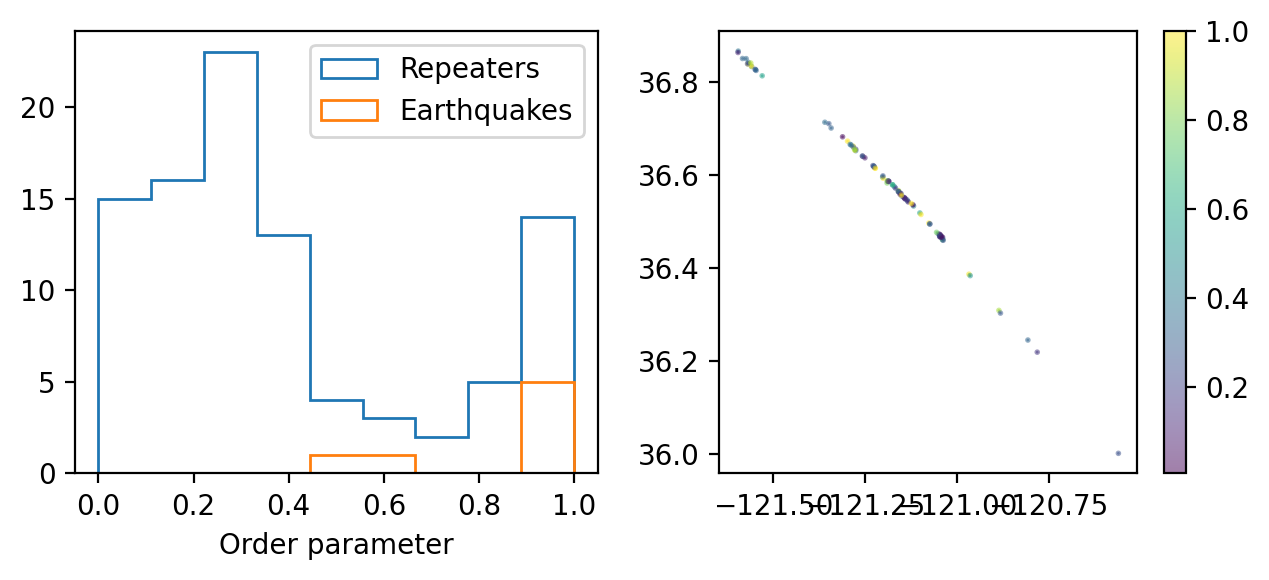

In [140]:
fig, AX = plt.subplots(1, 2, figsize=(6.5, 3), dpi=200)
ax = AX[0]
bins = np.linspace(0, 1, 10)
ax.hist(order_parameter, bins=bins, histtype="step", label="Repeaters")
ax.hist(earthquake_order_parameter, bins=bins, histtype="step", label="Earthquakes")
ax.set(xlabel="Order parameter")
ax.legend()
ax = AX[1]

lat = [f.catalog.lat.values[0] for f in families]
lon = [f.catalog.lon.values[0] for f in families]
ch = ax.scatter(lon, lat, c=order_parameter, s=1, alpha=0.5)
plt.colorbar(ch, ax=ax)
plt.tight_layout()

From this analysis, I conclude that some specific section seem more coherent than others. In particular then central Creeping section seem to feature more coherence than other sections.

[Text(0.5, 0, 'Number of nearby repeaters'), None]

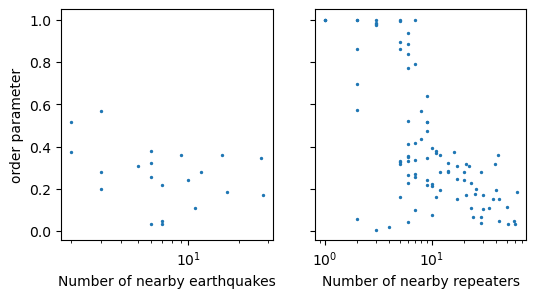

In [141]:
fig, [ax1, ax2] = plt.subplots(1, 2, sharey=True, figsize=(6, 3))
ax1.scatter(number_of_neighboring_earthquakes, order_parameter, s=2)
# ax1.scatter(number_of_neighboring_earthquakes, earthquake_order_parameter, s=2)
ax1.set(xlabel="Number of nearby earthquakes", ylabel="order parameter", xscale="log")

ax2.scatter(number_of_neighboring_repeaters, order_parameter, s=2)
# ax2.scatter(number_of_neighboring_repeaters, earthquake_order_parameter, s=2)
ax2.set(xlabel="Number of nearby repeaters", xscale="log")

Let's take a quick look at the families that are among well-synchronized repeaters:

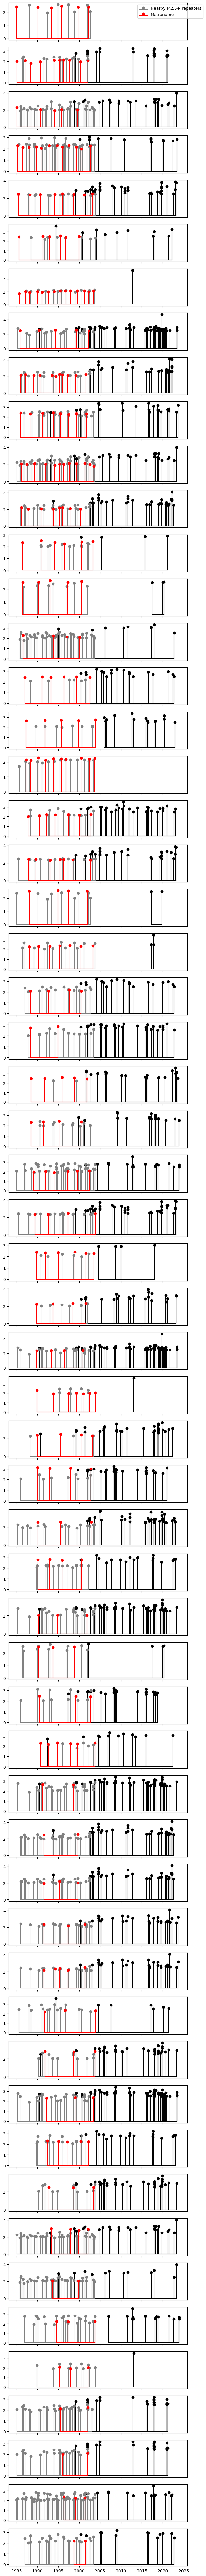

In [142]:
order_threshold = 0.25
fig, AX = plt.subplots(
    sum(order_parameter > order_threshold),
    1,
    figsize=(7, sum(order_parameter > order_threshold) * 1.5),
    sharex=True,
)

for i, family in enumerate(
    [f for f, r in zip(families, order_parameter) if r > order_threshold]
):

    family_ID = family.catalog.family.values[0]
    neighboring_repeaters = repeaters.intersection(family, search_radius)
    neighboring_earthquakes = nearby_earthquakes.intersection(family, search_radius)
    neighboring_repeaters.catalog = neighboring_repeaters.catalog.loc[
        neighboring_repeaters.catalog.family != family_ID
    ]

    # axb = AX[i].twinx()
    # axb.hist(
    #     neighboring_earthquakes.catalog.time,
    #     bins=50,
    #     label=f"M{minimum_avg_earthquake_magnitude}+ earthquakes",
    # )

    if np.any(neighboring_earthquakes.catalog.time.values):
        stem_2 = AX[i].stem(
            neighboring_earthquakes.catalog.time,
            neighboring_earthquakes.catalog.mag,
            label=f"Nearby M{minimum_avg_earthquake_magnitude}+ earthquakes",
        )
        plt.setp(stem_2, color="k")

    # axb.hist(
    #     neighboring_repeaters.catalog.time,
    #     bins=50,
    #     label=f"M{minimum_avg_earthquake_magnitude}+ earthquakes",
    #     alpha=0.5
    # )

    stem_2 = AX[i].stem(
        neighboring_repeaters.catalog.time,
        neighboring_repeaters.catalog.mag,
        label=f"Nearby M{minimum_avg_earthquake_magnitude}+ repeaters",
    )
    plt.setp(stem_2, color="grey")

    stem_1 = AX[i].stem(
        family.catalog.time,
        family.catalog.mag,
        label="Metronome",
    )
    plt.setp(stem_1, color="r")

AX[0].legend(bbox_to_anchor=[1.1, 1.0])

plt.tight_layout()

## Plot the order parameter on a sliding window for all events

[None]

/Users/kdascher/miniforge3/envs/eq_stats/lib/python3.10/site-packages/cartopy/mpl/style.py:76: UserWarning: facecolor will have no effect as it has been defined as "never".
  warnings.warn('facecolor will have no effect as it has been '


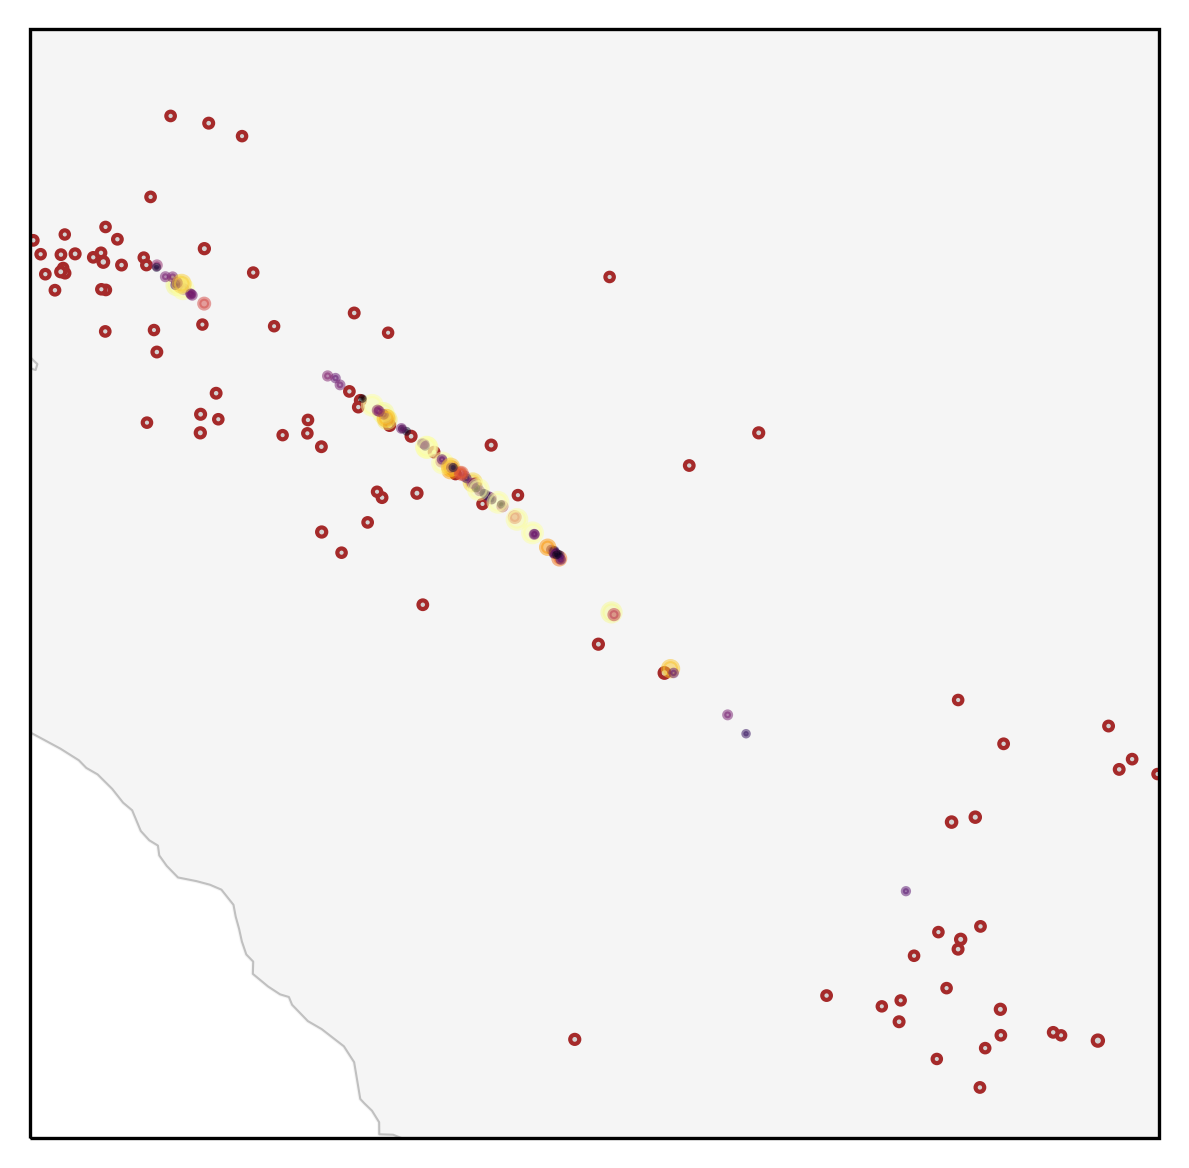

In [143]:
plt.rcParams['figure.dpi'] = 300
ax = nearby_earthquakes.slice_by("mag", 4).plot_map()
lat = [f.catalog.lat.values[0] for f in families]
lon = [f.catalog.lon.values[0] for f in families]
ax.scatter(lon, lat, c=order_parameter, s=np.exp(3*order_parameter),cmap='inferno',alpha=0.5)

new_buffer = 0.1
ax.set(
    extent=[
        repeaters.longitude_range[0] - new_buffer,
        repeaters.longitude_range[1] + new_buffer,
        repeaters.latitude_range[0] - new_buffer,
        repeaters.latitude_range[1] + new_buffer,
    ]
)